# Data Analysis and Data Extraction

---

## 1. Introduction

This notebook provides a reproducible and statistically grounded analysis to support Project 2.2: Hospital Simulation. The goal is to model patient arrivals and characteristics in an emergency department (ED) based on real-world data, enabling realistic input generation for a discrete-event simulation.

### Objectives

- Extract and preprocess historical ED visit data from HCUP (Healthcare Cost and Utilization Project) Excel files.
- Identify and model temporal trends in patient arrivals (monthly, daily, and hourly patterns).
- Estimate a sinusoidal function to capture seasonal variation in arrival rates.
- Derive multiplicative correction factors for day-of-week and time-of-day effects from external studies.
- Construct a diagnosis distribution for arriving patients based on pre-COVID empirical frequencies.

### Assumptions

1. **Data Reliability**: We assume that HCUP public data is accurate and representative of typical ED behavior in Oregon hospitals.
2. **Stationarity Pre-COVID**: Only data from 2017 to 2019 is used to avoid the confounding effects of the COVID-19 pandemic. We assume these years reflect a stationary process for modeling purposes.
3. **Seasonal Variation**: The observed monthly variation in ED arrivals is assumed to follow a sinusoidal trend, consistent with literature in healthcare operations.
4. **Additive Decomposition**: Arrival patterns are modeled using multiplicative factors:  
   $$
   \lambda(m, d, h) = f(m) \cdot F_\text{weekday}(d) \cdot F_\text{hour}(h)
   $$
   where each component is assumed to independently affect the arrival rate.
5. **Poisson Process**: Hourly patient arrivals are assumed to follow a Poisson distribution with the computed rate $\lambda$, in line with standard queuing and simulation modeling practices.
6. **Diagnosis Sampling**: Diagnoses are assigned independently using a discrete probability distribution estimated from historical frequencies. Co-morbidities and repeated visits are not modeled.

### Output

The result of this analysis is a parameterized arrival model and a diagnosis generator, both of which can be directly used as stochastic input functions in a discrete-event simulation of an ED.

All code, transformations, and assumptions are fully documented in the subsequent sections to ensure transparency and statistical rigor.


---

# 2. Data Loading and Preprocessing

This section outlines the loading and preparation of emergency department (ED) data from the Healthcare Cost and Utilization Project (HCUP). Two Excel files containing monthly summary statistics for Oregon are used:

- `HCUP_SummaryTrendTables_T1.xlsx`: Contains operational statistics such as ED volumes and admissions.
- `HCUP_SummaryTrendTables_T16a.xlsx`: Contains patient characteristics and diagnosis data.

The goal is to extract specific labeled sections from each file and prepare them for analysis.


## 2.1 Loading the Excel Data

We begin by loading the first Excel file and promoting the correct row to column headers. This is necessary due to inconsistent formatting (extra rows before headers) common in administrative Excel reports.


In [46]:
import pandas as pd

# Load the Excel file and select the relevant sheet
file_path = 'HCUP_SummaryTrendTables_T1.xlsx'
excel_file = pd.ExcelFile(file_path)
df = excel_file.parse('Oregon')  # Replace with actual sheet name if different

# Promote the 5th row as header and reset the index
df.columns = df.iloc[4]
df = df[4:].reset_index(drop=True)

## 2.2 Section Extraction Function

The HCUP data is divided into multiple labeled sections within a single sheet. We define a function to extract these sections based on a list of known labels.

**Function:** `extract_sections_from_excel`

This function searches for each label in the first column, determines the row index of the start of each section, and then extracts the data between those row markers. It also formats each extracted section for time series analysis.


In [47]:
import numpy as np
from typing import List, Dict

def extract_sections_from_excel(section_names: List[str], df: pd.DataFrame) -> Dict[str, pd.DataFrame]:
    # Drop empty rows/columns and trim whitespace
    df = df[df.iloc[:, 0].str.strip().astype(bool)]
    df = df.dropna(how='all', axis=0).dropna(how='all', axis=1)

    # Find section start indices
    section_starts = {}
    for name in section_names:
        match = df[df.iloc[:, 0].str.strip() == name]
        if not match.empty:
            section_starts[name] = match.index[0]
        else:
            print(f"Warning: Section '{name}' not found in the DataFrame.")

    # Sort sections and extract their respective data blocks
    sorted_sections = sorted(section_starts.items(), key=lambda x: x[1])
    sections = {}
    for i, (name, start_idx) in enumerate(sorted_sections):
        end_idx = sorted_sections[i + 1][1] if i + 1 < len(sorted_sections) else len(df)
        section_df = df.iloc[start_idx + 1:end_idx].copy()
        section_df.columns = df.columns

        # Transpose and clean the section
        formatted_section = section_df.iloc[:, 1:].T
        formatted_section.columns = section_df.iloc[:, 0].values
        formatted_section = formatted_section.apply(pd.to_numeric, errors='coerce')
        formatted_section.index = pd.to_datetime(formatted_section.index)
        formatted_section.index.name = 'Month'

        sections[name] = formatted_section

    return sections


## 2.3 Extracting Sections from T1

We define the list of ED-related metrics to extract from the first file:


In [48]:
section_names_T1 = [
    "Inpatient Stays",
    "Occupancy",
    "Intensive Care Use",
    "Intensive Care Beds",
    "Mechanical Ventilator Use",
    "Number of Mechanical Ventilators (outside of the operating rooms)",
    "Emergency Department (ED) Visits",
    "ED Volume",
    "ED Admission Rate"
]

sections_T1 = extract_sections_from_excel(section_names_T1, df)
print("Sections extracted:", list(sections_T1.keys()))

Sections extracted: ['Inpatient Stays', 'Occupancy', 'Intensive Care Use', 'Intensive Care Beds', 'Mechanical Ventilator Use', 'Number of Mechanical Ventilators (outside of the operating rooms)', 'Emergency Department (ED) Visits', 'ED Volume', 'ED Admission Rate']


## 2.4 Preprocessing the Diagnosis Data (T16a)

We repeat a similar process for the second file, which includes patient demographic and diagnosis-level detail:

In [49]:
# Load second file
file_path = 'HCUP_SummaryTrendTables_T16a.xlsx'
excel_file = pd.ExcelFile(file_path)
df = excel_file.parse('Oregon')

# Promote correct header row and reset index
df.columns = df.iloc[5]
df = df[5:].reset_index(drop=True)

# Define sections to extract
section_names_T16a = [
    "Number of ED  Visits for the Month",
    "Number of ED Treat-and-Release Visits by Priority Condition",
    "Number of ED Treat-and-Release Visits by Age in Years at Admission",
    "Number of ED Treat-and-Release Visits by Sex",
    "Number of ED Treat-and-Release Visits by Patient Race and Ethnicity",
    "Number of ED Treat-and-Release Visits by Urban-Rural Location of Patient's Residence",
    "Number of ED Treat-and-Release Visits by Community Income",
    "Number of ED Treat-and-Release Visits by Expected Primary Payer",
    "Number of ED Treat-and-Release Visits by Urban-Rural Location of the Hospital",
    "Number of ED Treat-and-Release Visits for Top Conditions Defined by First-Listed Diagnosis",
    "Number of ED Treat-and-Release Visits for Symptoms Defined by Any-Listed Diagnosis"
]

sections_T16a = extract_sections_from_excel(section_names_T16a, df)
print("Sections extracted:", list(sections_T16a.keys()))

Sections extracted: ['Number of ED  Visits for the Month', 'Number of ED Treat-and-Release Visits by Priority Condition', 'Number of ED Treat-and-Release Visits by Age in Years at Admission', 'Number of ED Treat-and-Release Visits by Sex', 'Number of ED Treat-and-Release Visits by Patient Race and Ethnicity', "Number of ED Treat-and-Release Visits by Urban-Rural Location of Patient's Residence", 'Number of ED Treat-and-Release Visits by Community Income', 'Number of ED Treat-and-Release Visits by Expected Primary Payer', 'Number of ED Treat-and-Release Visits by Urban-Rural Location of the Hospital', 'Number of ED Treat-and-Release Visits for Top Conditions Defined by First-Listed Diagnosis', 'Number of ED Treat-and-Release Visits for Symptoms Defined by Any-Listed Diagnosis']


## 2.5 Assumptions and Considerations

* **Time Indexing**: All monthly data is assumed to be reported with the first day of each month as its timestamp (e.g., `2017-01-01` for January 2017).
* **Section Names**: Section names are extracted manually from the file to ensure correct and relevant section are used.
* **Missing Data**: Missing values from formatting issues or inconsistent Excel structure are handled via automatic `NaN` propagation.
* **Consistency**: Preprocessing is identical across files to ensure compatibility in downstream modeling.

At this stage, the relevant sections from both Excel files are cleaned, indexed by month, and stored in a dictionary format for further analysis. The next step involves analyzing temporal trends in ED arrivals.

---

# 3. Seasonal Trend Analysis

In this section, we analyze monthly trends in emergency department (ED) arrivals to detect and model seasonal variation. This is critical for generating realistic inputs to the hospital simulation model.

We focus exclusively on the pre-COVID period (January 2017 to December 2019) to ensure that pandemic-related anomalies do not distort the underlying seasonal patterns.

## 3.1 Data Selection

We extract the section labeled `"ED Volume"` from the `sections_T1` dictionary and focus on three daily volume metrics:

- Average daily volume
- Minimum daily volume
- Maximum daily volume

We limit the analysis to data before January 2020:

In [50]:
ed_visits = sections_T1['ED Volume'][
    ['Average daily volume for all ED visits', 
     'Minimum daily volume for all ED visits', 
     'Maximum daily volume for all ED visits']
]

# Exclude COVID-19 period
pre_covid = ed_visits.loc[ed_visits.index < '2020-01-01']

## 3.2 Monthly Averages

To analyze seasonal trends, we compute the average number of ED visits for each calendar month (January through December) over the pre-COVID years:


In [51]:
# Group by month number (1 = January, ..., 12 = December)
monthly_avg = pre_covid.groupby(pre_covid.index.month)[
    'Average daily volume for all ED visits'
].mean()

months = np.arange(1, 13)  # Month numbers for plotting

## 3.3 Model Assumption

We assume the monthly pattern follows a **sinusoidal function**, commonly used in healthcare operations literature to model periodic behavior:

$$
f(m) = A \cdot \sin\left(\frac{2\pi(m - 1)}{12} + \phi\right) + B
$$

Where:

* $m$ is the month number (1–12),
* $A$ is the amplitude (magnitude of seasonal variation),
* $\phi$ is the phase shift (timing offset),
* $B$ is the baseline (average volume).

## 3.4 Curve Fitting

We fit the sinusoidal function to the monthly average data using non-linear least squares via `scipy.optimize.curve_fit`.


In [52]:
from scipy.optimize import curve_fit
import numpy as np

# Define sinusoidal function
def seasonal_func(t, A, phi, B):
    return A * np.sin(2 * np.pi * (t - 1) / 12 + phi) + B

# Fit the curve
params, _ = curve_fit(seasonal_func, months, monthly_avg.values)
A, phi, B = params
print(f"Fitted parameters: A = {A:.2f}, phi = {phi:.2f}, B = {B:.2f}")

Fitted parameters: A = 87.81, phi = 0.13, B = 4237.56


**Fitted Parameters:**

* Amplitude $A = 87.81$
* Phase shift $\phi = 0.13$
* Baseline $B = 4237.56$

## 3.5 Visualization

The plot below shows the observed average ED arrivals by month, with the fitted seasonal curve overlaid.


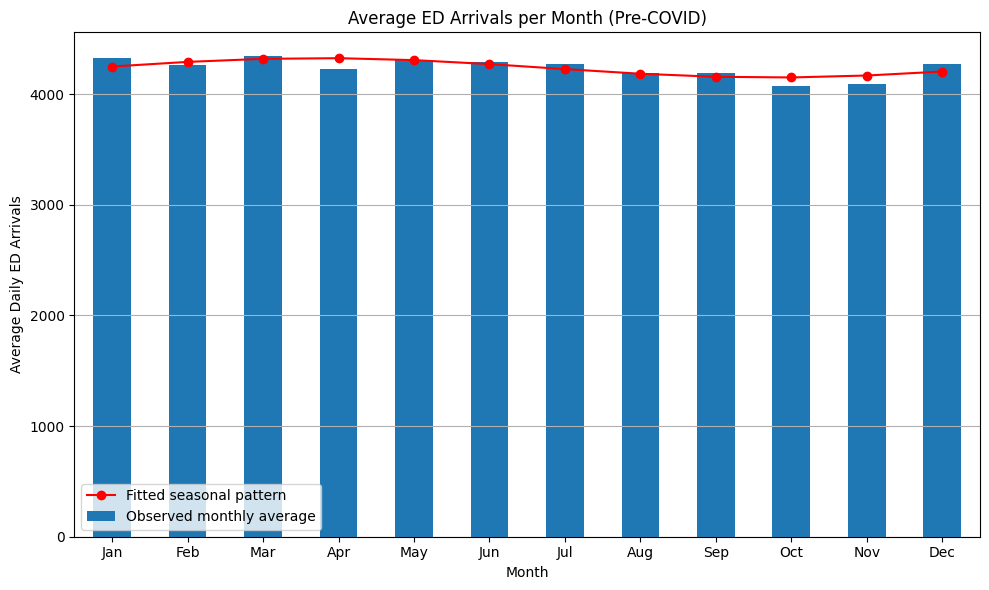

In [53]:
import matplotlib.pyplot as plt

ax = monthly_avg.plot(kind='bar', figsize=(10, 6), label='Observed monthly average')
ax.plot(months - 1, seasonal_func(months, *params), color='red', marker='o', linestyle='-', label='Fitted seasonal pattern')

plt.xlabel('Month')
plt.ylabel('Average Daily ED Arrivals')
plt.title('Average ED Arrivals per Month (Pre-COVID)')
plt.xticks(ticks=np.arange(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0)
plt.grid(axis='y')
plt.legend()
plt.tight_layout()
plt.show()

## 3.6 Interpretation

The fitted curve confirms moderate seasonal variation in ED arrivals:

* Higher volumes in winter months (December–February),
* Lower volumes in summer (June–August),
* Overall fluctuation of about ±2% from the baseline.

This seasonal pattern is consistent with healthcare literature (e.g., Gabbay et al., 2022), and the resulting function $f(m)$ is used in the simulation to modulate the base arrival rate by month.


## 3.7 Assumptions

* **Seasonality is sinusoidal**: We assume no sharp or non-periodic effects beyond the smooth seasonal pattern.
* **Years are exchangeable**: January 2017, 2018, and 2019 are considered comparable and averaged together.
* **No trend**: No year-over-year growth or decline is modeled; the focus is purely on intra-year seasonality.

This concludes the estimation of seasonal variation in ED arrivals. The next section will explore further adjustments based on day-of-week and time-of-day effects.

--- 

# 4. Weekday and Hourly Patterns

In addition to seasonal variation, patient arrivals to emergency departments (EDs) exhibit predictable patterns by **day of the week** and **hour of the day**. These finer time resolutions are essential to accurately simulate temporal load fluctuations in a hospital setting.

## 4.1 Day-of-the-Week Variation

### Observed Trend (Literature-Based)

Multiple studies (e.g., Gabbay et al., 2022; CDC NHAMCS 2019) report the following pattern:

- **Highest volume on Mondays**, due to deferred weekend care.
- **Lower volumes midweek**, gradually declining.
- **Lowest arrivals on Sundays**.

### Assumption

Because direct day-of-week counts are not available in the dataset, we rely on external literature to define multiplicative factors that scale the monthly average volume per weekday:

$$
F_\text{weekday}(d) = [0.8647,\, 1.1324,\, 1.0294,\, 1.0294,\, 1.0294,\, 1.0088,\, 0.9059]
$$
This array corresponds to:  **[Sunday, Monday, Tuesday, Wednesday, Thursday, Friday, Saturday]**

<p align="center">
    <img src="images/Variation-in-number-of-ED-admissions-on-different-days-of-the-week.png" alt="Variation in number of ED admissions on different days of the week" width="50%">
</p>

## 4.2 Hour-of-the-Day Variation

### Observed Trend (Literature-Based)

ED arrivals also follow a diurnal pattern:

- **Lowest volumes early morning (00:00–06:00)**.
- **Sharp increase from 08:00**, peaking late morning to early evening.
- **Gradual decline overnight**.

This shape is widely reported in operational studies of EDs (e.g., ACEPNow, 2022; NHAMCS).

### Hourly Factors

We define a 24-element vector $F_\text{hour}(h)$ giving a multiplicative weight per hour $h = 0, 1, ..., 23$:

In [54]:
hour_factors = [
    0.5236, 0.48, 0.4364, 0.3927, 0.3927, 0.3927,
    0.3927, 0.5236, 0.96, 1.5273, 1.7455, 1.6582,
    1.44, 1.3091, 1.6582, 1.3964, 1.1782, 1.1782,
    1.1782, 1.1782, 1.1782, 1.1782, 0.96, 0.7418
]

These factors are normalized around the peak period and based on relative activity proportions from published datasets.

### Visualization

<p align="center">
    <img src="images/Variation-in-number-of-ED-admissions-at-different-times-of-day.png" alt="Variation in number of ED admissions on different days of the week" width="50%">
</p>

## 4.3 Combined Arrival Model

Combining all temporal components, the estimated arrival rate $\lambda(m, d, h)$ for a given hour $h$ on date $d$ in month $m$ is defined as:

$$
\lambda(m, d, h) = f(m) \cdot F_\text{weekday}(d) \cdot F_\text{hour}(h)
$$

Where:

* $f(m)$ is the monthly seasonal trend (see Section 3),
* $F_\text{weekday}(d)$ scales based on the day of the week,
* $F_\text{hour}(h)$ scales based on time of day.

This dynamic function allows the simulation to reflect realistic fluctuations in arrival intensity across time scales.

## 4.4 Assumptions

* **Independence**: Monthly, weekday, and hourly variations are treated as independent multiplicative factors.
* **External calibration**: Day and hour factors are based on literature due to lack of temporal granularity in the dataset.
* **Normalization**: All factors are relative and centered around the average daily arrival rate.

This concludes the time-based modeling of ED arrival patterns. The next section focuses on assigning diagnoses to arriving patients.


---

# 5. Diagnosis Distribution

To simulate patient flow realistically, each arriving patient must be assigned a plausible diagnosis. This section derives a diagnosis distribution based on pre-COVID emergency department (ED) visit data from the HCUP T16a dataset.




## 5.1 Data Source and Selection

We use the section titled:

**"Number of ED Treat-and-Release Visits for Symptoms Defined by Any-Listed Diagnosis"**

This section includes monthly visit counts for symptom-level diagnosis codes labeled as `SYM001` through `SYM017`.

### Data Extraction:


In [55]:
ed_diagnosis = sections_T16a[
    'Number of ED Treat-and-Release Visits for Symptoms Defined by Any-Listed Diagnosis'
]

# Keep only pre-COVID records
pre_covid_diagnosis = ed_diagnosis.loc[ed_diagnosis.index < '2020-01-01']

## 5.2 Total Visit Counts per Diagnosis

We compute the total number of ED visits for each diagnosis code across all pre-COVID months:

In [56]:
# Sum across all months
diagnosis_totals = pre_covid_diagnosis.sum(axis=0)

# Extract clean SYM code labels (drop long text descriptions)
diagnosis_totals.index = diagnosis_totals.index.str.extract(r'(SYM\d+)', expand=False)

## 5.3 Probability Distribution

The counts are normalized into a discrete probability distribution to be used for random sampling during simulation.
The chart below shows the total ED visits per diagnosis code from 2017–2019:

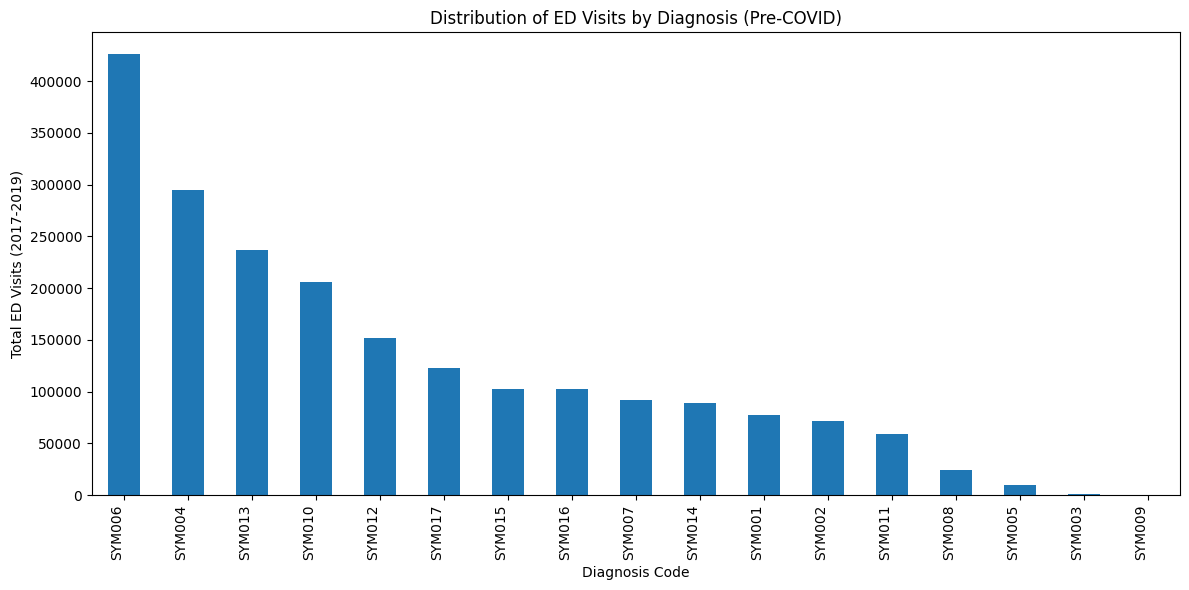

In [57]:
# Calculate total ED visits for each diagnosis code (sum over all months, pre-COVID)
diagnosis_totals = pre_covid_diagnosis.sum(axis=0)

# Transform the labels to only include the SYM code
diagnosis_totals.index = diagnosis_totals.index.str.extract(r'(SYM\d+)', expand=False)

# Plot as a bar chart
plt.figure(figsize=(12, 6))
diagnosis_totals.sort_values(ascending=False).plot(kind='bar')
plt.ylabel('Total ED Visits (2017-2019)')
plt.xlabel('Diagnosis Code')
plt.title('Distribution of ED Visits by Diagnosis (Pre-COVID)')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()


## 5.5 Diagnosis Codes

| Code   | Description                                |
| ------ | ------------------------------------------ |
| SYM001 | Syncope                                    |
| SYM002 | Fever                                      |
| SYM003 | Shock                                      |
| SYM004 | Nausea and vomiting                        |
| SYM005 | Dysphagia                                  |
| SYM006 | Abdominal/digestive symptoms               |
| SYM007 | Malaise and fatigue                        |
| SYM008 | Mental and substance use symptoms          |
| SYM009 | Abnormal findings related to substance use |
| SYM010 | Nervous system symptoms                    |
| SYM011 | Genitourinary symptoms                     |
| SYM012 | Circulatory symptoms                       |
| SYM013 | Respiratory symptoms                       |
| SYM014 | Skin/subcutaneous symptoms                 |
| SYM015 | Sensation/perception symptoms              |
| SYM016 | Other general symptoms                     |
| SYM017 | Abnormal findings without diagnosis        |

---

## 5.6 Assumptions

* **Independence**: Each diagnosis is sampled independently of others and of the time of arrival.
* **Single-diagnosis model**: Each patient is assigned only one diagnosis code, simplifying multi-morbidity.
* **Symptom-based coding**: Diagnosis probabilities are based on high-level symptom codes, not specific ICD-10 conditions.
* **Historical stability**: The diagnosis distribution is assumed to be representative of future patterns, based on pre-COVID years.

This concludes the derivation of the diagnosis distribution. The final section summarizes how all components are integrated into the arrival rate used for simulation.

```